# Fidimag: A Basic Simulation

This notebook is a guide to the essential commands required to write and run basic Fidimag simulations.

The first step is to import Fidimag. Numpy and Matplotlib are also imported for later use, to demonstrate visualising simulations results.

In [1]:
import fidimag
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Meshes

                           Mesh                                              Cell
                                                                        +------------+
          +-----+-----+-----+-----+-----+-----+                        /            /|
         /     /     /     /     /     /     /|                       /            / |
        +-----+-----+-----+-----+-----+-----+ |                      /            /  | dz
       /     /     /     /     /     /     /| +                     +------------+   |
      +-----+-----+-----+-----+-----+-----+ |/          ----->      |            |   |
     /     /     /     /     /     /     /| +                       |            |   + 
    +-----+-----+-----+-----+-----+-----+ |/                        |            |  /
    |     |     |     |     |     |     | +                         |            | /  dy
    |     |     |     |     |     |     |/                          |            |/
    +-----+-----+-----+-----+-----+-----+                           +------------+
                                                                         dx

We need to create a mesh. Meshes are created by specifying the dimensions of the finite difference cells, (dx, dy, dz) and the number of cells in each direction, (nx, ny, nz).

The cell dimensions are defined by dimensionless units. The dimensions of the mesh/cells are integrated by the parameter, unit_length.

In the the following example, the (cuboid) mesh consists of 50x20x1 cells (nx=50, ny=20 and nz=1), with each cell comprising of the dimensions, dx=3, dy=3 and dz=4. The unit_length = 1e-9 (nm).

Thus, the total size of the mesh is 150nm x 60nm x 4nm.

***Required Fidimag Function***

`fidimag.common.CuboidMesh(nx, ny, nz, dx, dy, dz, unit_length)`




In [2]:
nx, ny, nz = 50, 20, 1
dx, dy, dz = 3, 3, 4 #nm
unit_length = 1e-9 # define the unit length of the dx units to nm.

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, unit_length=unit_length)

## Creating the Simulation Object

Now we can create the simulation object.

A mesh is required to create a simulation object. We also give the simulation object a name. Is this case, we call the simulation object, `sim_tutorial_basics`

***Required Fidimag Function***

`fidimag.micro.Sim(mesh, name)`

In [3]:
sim_name = 'sim_tutorial_basics'

sim = fidimag.micro.Sim(mesh, name=sim_name)

## Adding Interactions (and specifying material parameters)

The material specific interactions (and parameters) can now be added to the simulation object. Let's first specify the material specific parameters:

In [4]:
Ms = 1e6  # magnetisation saturation (A/m)
A = 1e-12  # exchange energy constant (J/m)
D = 1e-3  # DMI constant (J/m**2)
Ku = 1e5  # uniaxial anisotropy constant (J/m**3)
Kaxis = (0, 0, 1)  # uniaxial anisotropy axis
H = (0, 0, 1e3)  # external magnetic field (A/m)

The simulation object, sim created earlier has a property for the saturation magnetisation, Ms which is set in the following way:

In [5]:
sim.Ms = 8.0e5

Now let's add the following interactions:

- Exchange
- Uniaxial Anisotropy
- Dyzaloshinskii-Moriya (bulk)
- Zeeman Field
- Demagnetisation

***Required Fidimag Functions***

to a simulation object named, sim:

- `sim.add(interaction)`

where the interactions are:

| interaction         | function                                             |
|---------------------|------------------------------------------------------|
| exchange            | `fidimag.micro.UniformExchange(A)`                   |
| uniaxial anisotropy | `fidimag.micro.UniaxialAnisotropy(Ku, axis)`         |
| DMI                 | `fidimag.micro.DMI(D)`                               |
| Zeeman              | `fidimag.micro.Zeeman(H0)`                           |
| Demag               | `fidimag.micro.Demag()`                              |

In [6]:
exchange = fidimag.micro.UniformExchange(A=A)
sim.add(exchange)

anis = fidimag.micro.UniaxialAnisotropy(Ku=Ku, axis=Kaxis)
sim.add(anis)

dmi = fidimag.micro.DMI(D=D)
sim.add(dmi)

zeeman = fidimag.micro.Zeeman(H0=H)
sim.add(zeeman)

demag = fidimag.micro.Demag()
sim.add(demag)

So, at this point the Hamiltonian is created. Now, we can set parameters in the LLG equation. The sim object has properties for the values of `alpha` and `gamma` which are set in the following way:


In [7]:
sim.alpha = 0.5
sim.gamma = 2.211e5
# sim.do_precession = True

You can also specfiy whether the magnetisation spins precess or not. The sim object has a property, `do_precession`, which can be set to either `True` of `False`. In this example, let's have precession:

In [8]:
sim.do_precession = True

When both Hamiltonian and LLG equations are set, we need to set the intial magnetisation before we relax the system. Let's set it to all point in the x-direction:

In [9]:
m_init = (1,0,0)
sim.set_m(m_init)

## Relaxing the Simulation

The simulation object is now set up: we're now ready to relax the magnetisation.

### Time Integrator Parameters

In order to do so, we need to specify the value of dt for the time integration. By default this is set to dt=1e-11.

We also need to tell the simulation when to stop, through the desired stoppping precision, `stopping_dmdt`. By default this is set to `stopping_dmdt=0.01`.

The maximum number of steps, `max_steps` the time integrator take also needs to be specified. By default this is set to 1000.

### Data Saving Parameters

Within the relax function, when to save the magnetisation, `save_m_steps`, and vtk files of the magnetisation, `save_vtk_steps`, are also specified. By default they are set to save every 100 steps that the integrator takes. The final magnetisation is also saved. In this example we save the spatial magnetisation every 10 time steps.

When the relax function is called, a text file containing simulation data (including time, energies and average magnetisation) is created with the name `sim_name.txt`.

Sub-directories for the (spatial) magnetisation and vtk files are also created with the names, `sim_name_npys` and `sim_name_vtks` respectively, where the relevant data is subsequently saved. The names of these files are `m_*.npy` and `m_*******.vts` respectively, where `*` is replaced with the time integrator step (with leading zeros for the vts (vtk) file).

***Required Fidimag Function***

`sim.relax(dt, stopping_dmdt, max_steps, save_m_steps, save_vtk_steps)`

In [10]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
sim.relax(dt=1e-11, stopping_dmdt=0.01, max_steps=200, save_m_steps=10, save_vtk_steps=100)

	Using lookup_table='default'


step=1, time=1e-11, max_dmdt=3.82e+03 ode_step=0
step=2, time=2e-11, max_dmdt=3.4e+03 ode_step=3.97e-13
step=3, time=3e-11, max_dmdt=2.5e+03 ode_step=3.97e-13
step=4, time=4e-11, max_dmdt=1.9e+03 ode_step=3.97e-13
step=5, time=5e-11, max_dmdt=1.74e+03 ode_step=5.97e-13
step=6, time=6e-11, max_dmdt=1.42e+03 ode_step=5.97e-13
step=7, time=7e-11, max_dmdt=1.67e+03 ode_step=5.97e-13
step=8, time=8e-11, max_dmdt=2.19e+03 ode_step=8.96e-13
step=9, time=9e-11, max_dmdt=3.03e+03 ode_step=8.96e-13
step=10, time=1e-10, max_dmdt=3.49e+03 ode_step=6.64e-13
step=11, time=1.1e-10, max_dmdt=3.29e+03 ode_step=6.64e-13
step=12, time=1.2e-10, max_dmdt=3.07e+03 ode_step=4.92e-13
step=13, time=1.3e-10, max_dmdt=2.85e+03 ode_step=4.92e-13
step=14, time=1.4e-10, max_dmdt=2.37e+03 ode_step=4.92e-13
step=15, time=1.5e-10, max_dmdt=2.2e+03 ode_step=7.41e-13
step=16, time=1.6e-10, max_dmdt=2.41e+03 ode_step=7.41e-13
step=17, time=1.7e-10, max_dmdt=2.46e+03 ode_step=7.41e-13
step=18, time=1.8e-10, max_dmdt=2.81e

	Using lookup_table='default'


step=106, time=1.06e-09, max_dmdt=1.11e+03 ode_step=7.67e-13
step=107, time=1.07e-09, max_dmdt=729 ode_step=7.67e-13
step=108, time=1.08e-09, max_dmdt=611 ode_step=7.67e-13
step=109, time=1.09e-09, max_dmdt=453 ode_step=7.67e-13
step=110, time=1.1e-09, max_dmdt=372 ode_step=7.67e-13
step=111, time=1.11e-09, max_dmdt=366 ode_step=7.67e-13
step=112, time=1.12e-09, max_dmdt=371 ode_step=1.17e-12
step=113, time=1.13e-09, max_dmdt=375 ode_step=1.17e-12
step=114, time=1.14e-09, max_dmdt=341 ode_step=1.92e-12
step=115, time=1.15e-09, max_dmdt=278 ode_step=1.92e-12
step=116, time=1.16e-09, max_dmdt=209 ode_step=1.92e-12
step=117, time=1.17e-09, max_dmdt=207 ode_step=1.92e-12
step=118, time=1.18e-09, max_dmdt=194 ode_step=1.92e-12
step=119, time=1.19e-09, max_dmdt=193 ode_step=2.9e-12
step=120, time=1.2e-09, max_dmdt=195 ode_step=2.9e-12
step=121, time=1.21e-09, max_dmdt=191 ode_step=2.9e-12
step=122, time=1.22e-09, max_dmdt=182 ode_step=2.9e-12
step=123, time=1.23e-09, max_dmdt=178 ode_step=2.

	Using lookup_table='default'
	Using lookup_table='default'


# Inspecting the data

Now that a simulation has run, it is useful to inspect and visualise the generated data.

## Structure of (spatial) m array

The spatial magnetisation array from the last relaxation step can be accessed via `sim.spin`. We also saved the spatial magnetisation for all time steps into the folder *sim\_basics\_tutorial\_npys*.

The structure of `sim.spin` (and the also the data saved in the *.npy* files) is an 1-dimensional. For a mesh with *n* cells, the components are ordered as follows:

`[mx(0), my(0), mz(0), mx(1), my(1), mz(1), ..., mx(n), my(n), mz(n)]`

where the numbering of the mesh cell adheres to the following convention:

        +-------+
     .'       .:|
    +-------+:::|
    |       |:::|
    |   30  |::;+-------+-------+-------+-------+-------+
    |       |;'       .:| 11  .'  12  .'  13  .'  14  .:|
    +-------+-------+:::|---+-------+-------+-------+:::|
    |       |       |:::| .'   7  .'   8  .'   9  .:|:::|
    |   15  |  16   |::;+-------+-------+-------+:::|:::+
    |       |       |;'       .'      .'      .:|:::|::'
    +-------+-------+-------+-------+-------+:::|:::+'
    |       |       |       |       |       |:::|:.'
    |   0   |   1   |   2   |   3   |   4   |:::+'
    |       |       |       |       |       |::'
    +-------+-------+-------+-------+-------+'


## Plotting m (spatial)
It is useful to reshape the 1-D magnetisation array into 2- or 3-D in order to create spatial plots of the magnetisation.

This is done via the following steps:

1. Reshape the data into ``[[mx(0), mx(1), ..., mx(n)], [my(0), my(1), ..., my(n)], [mz(0), mz(1), ..., mz(n)]]``. e.g. the values of each different magnetisation component, mx, my, mz are grouped together
2. Extract the values of the magnetisation component required.
3. Reshape the magnetisation component into the relevant number of dimensions.
4. Extract a layer of data if required.

In [11]:
# Use the most current values of m on the simulation object
m = sim.spin

# We could also use the some of data saved from the simulation. In which case, we need to load the data
# saved at one of the timesteps. Here we looad the data saved at the 201st timestep:
# m = np.load('sim_tutorial_basics_npys/m_201.npy')

# 1. Reshape m into [[mx], [my], [mz]]
m.shape = (-1,3)
# 2. Extract the required component of the magnetisation. In this case, we extract the values of mz.
mz = m[:,2]

In [12]:
# 3. Reshape into the relevant number of dimensions. In this example, we reshape into 2-D
# note, the data shape should be (nz,ny,nx) rather than (nx,ny,nz). This can be transposed if required.
mz.shape = (nz, ny, nx)
# 4. Extract the 2D layer of data required. Here we extract the xy-plane of data. We only have once layer
# in the z-direction.
mz_layer = mz[0,:,:]

# Transpose the data if you require it in the shape (nx, ny, nz)
# mz_layer = mz_layer.T

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


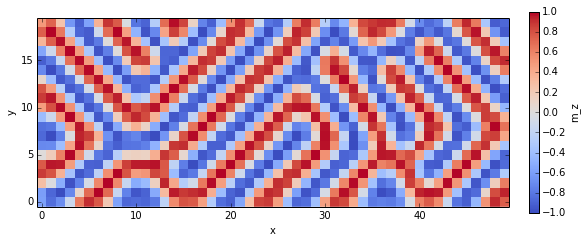

In [13]:
# Plot the data. Here we use imshow, so we want to use the data in the (ny, nx) shape so that the
# data is displayed correctly.
plt.figure(figsize=(9,6))
plot = plt.imshow(mz_layer, aspect=1, cmap=plt.cm.coolwarm, origin='lower', interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(plot,fraction=0.02, pad=0.04, label='m_z')

plt.show()

## Plotting m (average)

It is also useful to plot the average components of m over time. The simulation data has been written into the file, `sim_tutorial_basics.txt`. We can see this has been written into the current working directory.

### Loading the data

There is a helper function in fidimag, `DataReader` for reading in the saved data. The data is in the form of a dictionary, so we can see what data is available by listing the entities.

In this example, we load the average z-component of the magnetisation, m$_{x}$ and and the times, t and plot them.

***Required Fidimag Function***

`fidimag.common.fileio.DataReader('datafile.txt')`

In [14]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
# show the contents of the current directory.
%ls

1d_domain_wall.ipynb              sim_tutorial_basics_vtks/
current-driven-domain-wall.ipynb  spin-polarised-current-driven-skyrmion.ipynb
isolated_skyrmion.ipynb           spin-waves-in-periodic-system.ipynb
runtimes.org                      standard_problem_4.ipynb
sanitize_file                     tutorial-basics.ipynb
sim_tutorial_basics_npys/         tutorial-docker-container.ipynb
sim_tutorial_basics.txt


In [15]:
# Load the data
f = fidimag.common.fileio.DataReader('sim_tutorial_basics.txt')

In [16]:
# Lst the data available
f.entities()

['rhs_evals',
 'step',
 'E_UniformExchange',
 'E_total',
 'm_error',
 'real_time',
 'E_Zeeman',
 'm_z',
 'm_y',
 'm_x',
 'time',
 'skx_num',
 'E_Demag',
 'E_Anisotropy',
 'E_DMI']

In [17]:
# extract m_x
mx = f['m_x']
# extract the times, in nm
t = f['time']/1e-9

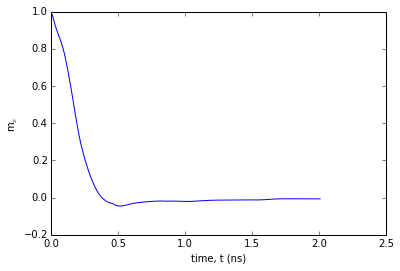

In [18]:
# plot the data
plt.plot(t, mx)
plt.xlabel('time, t (ns)')
plt.ylabel(r'm${_x}$')
plt.show()